In [1]:
import numpy as np
%matplotlib inline

# NOTE: we are storing y's as 1's or 0's but still doing the mean stuff correctly
def get_sample(n, mean, var):
    x_sample = []
    y_sample = []
    for i in range(n):
        y = np.random.binomial(1, .5)
        if (y == 0):
            x = np.random.normal(-mean, var)
        else:
            x = np.random.normal(mean, var)
        x_sample.append(x)
        y_sample.append(y)
    return x_sample, y_sample

import seaborn as sns
import matplotlib.pyplot as plt


def split_by_class(sample):
    y_one = [pair for pair in sample if pair[1] == 1]
    y_neg_one = [pair for pair in sample if pair[1] == 0]
    return y_one, y_neg_one

X, y = get_sample(5000, 2, 1)
sample = list(zip(X, y))
class_two, class_neg_two = split_by_class(sample)



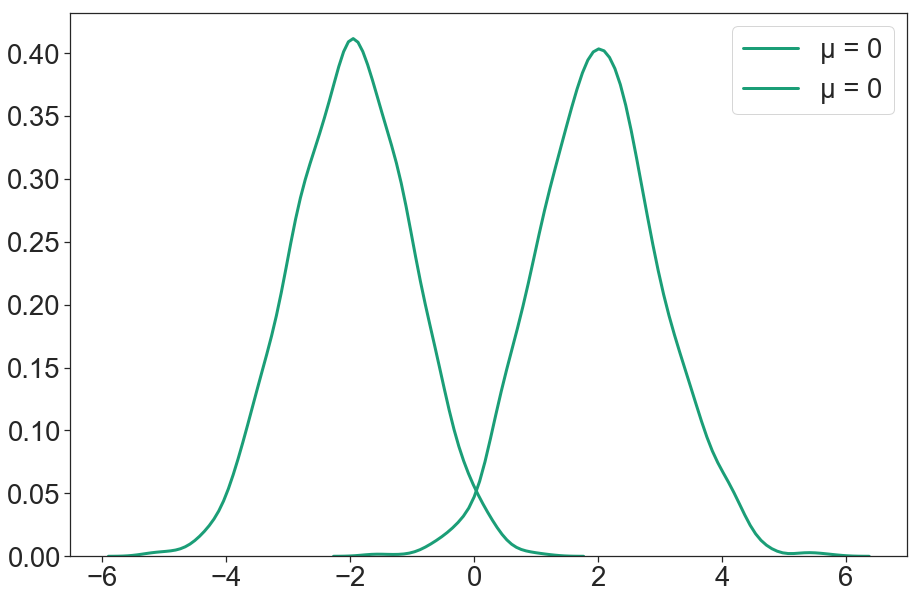

In [2]:
sns.set(font_scale = 2.5)
sns.set_style("ticks")
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams['figure.figsize'] = [15, 10]
plt.rcParams['lines.linewidth'] = 3
plt.figure()

sns.distplot(list(zip(*class_two))[0], hist=False, color = "#1b9e77", label = u'\u03bc = 0')
sns.distplot(list(zip(*class_neg_two))[0], hist=False, color = "#1b9e77", label = u'\u03bc = 0')

In [20]:
from sklearn.ensemble.forest import _generate_unsampled_indices
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import math


def rf_entropy_estimate_bagging_revised(X, y, n_estimators = 300, nu = .33, bootstrap = True, depth = 30, min_samples_leaf = 1, max_features = 1.):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=nu, random_state=42)
    
    max_samples = int(len(X_train)*.5)
    split_samples = max_samples // 2
    model = BaggingClassifier(DecisionTreeClassifier(max_depth = depth, min_samples_leaf = min_samples_leaf, max_features = math.ceil(int(math.sqrt(X.shape[1])))), 
                              n_estimators = n_estimators, 
                              max_samples= split_samples, 
                              bootstrap = bootstrap)
    model.fit(X_train, y_train)
    class_counts = np.zeros((X_test.shape[0], model.n_classes_))
    for tree in model:
        # get out of bag indicies
        unsampled_indices = _generate_unsampled_indices(tree.random_state, len(X))
        
        total_unsampled = len(unsampled_indices)
        np.random.shuffle(unsampled_indices)
        prob_indices = unsampled_indices[:split_samples]

        # get all node counts
        node_counts = tree.tree_.n_node_samples
        # get probs for eval samples
        posterior_class_counts = np.zeros((len(node_counts), model.n_classes_))
        for prob_index in unsampled_indices:
            posterior_class_counts[tree.apply(X[prob_index].reshape(1, -1)).item(), y[prob_index]] += 1
        row_sums = posterior_class_counts.sum(axis=1)
        row_sums[row_sums == 0] = 1
        class_probs = (posterior_class_counts/row_sums[:, None])
        
        where_0 = np.argwhere(class_probs == 0)
        for elem in where_0:
            class_probs[elem[0], elem[1]] = 1/(model.n_classes_*row_sums[elem[0], None])
        where_1 = np.argwhere(class_probs == 1)
        for elem in where_1:
            class_probs[elem[0], elem[1]] = 1 - (model.n_classes_ - 1)/(model.n_classes_*row_sums[elem[0], None])
        
        class_probs.tolist()
        partition_counts = np.asarray([node_counts[x] for x in tree.apply(X_test)])
        # get probability for out of bag samples
        eval_class_probs = [class_probs[x] for x in tree.apply(X_test)]
        eval_class_probs = np.array(eval_class_probs)
        # find total elements for out of bag samples
        elems = np.multiply(eval_class_probs, partition_counts[:, np.newaxis])
        # store counts for each x (repeat fhis for each tree)
        class_counts += elems
    # calculate p(y|X = x) for all x's
    probs = class_counts/class_counts.sum(axis = 1, keepdims = True)
    print(probs)
    entropies = -np.sum(np.log(probs)*probs, axis = 1)
    # convert nan to 0
    entropies = np.nan_to_num(entropies)
    return np.mean(entropies)

from scipy.stats import entropy

def get_entropy(X):
    probs = np.bincount(X)/len(X)
    return entropy(probs)

def get_mutual_information(X, y, n_estimators = 1000):
    cond_entropy = rf_entropy_estimate_bagging_revised(X, y, n_estimators = n_estimators)
    h_y = get_entropy(y)
    return h_y - cond_entropy


np.warnings.filterwarnings('ignore')


In [9]:
X, y = get_sample(10000, 1, 1)


In [10]:
rf_entropy_estimate_bagging_revised(np.array(X).reshape(-1, 1), y)

[[0.93941421 0.06058579]
 [0.51563283 0.48436717]
 [0.90314562 0.09685438]
 ...
 [0.03828684 0.96171316]
 [0.99277368 0.00722632]
 [0.27080453 0.72919547]]


0.33212108770818055

In [11]:
from sklearn.ensemble.forest import _generate_unsampled_indices
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
import math


def rf_entropy_estimate_bagging(X, y, n_estimators = 200, max_samples = .32, bootstrap = True, depth = 30, min_samples_leaf = 1, max_features = 1.):
    model = BaggingClassifier(DecisionTreeClassifier(max_depth = depth, min_samples_leaf = min_samples_leaf, max_features = math.ceil(int(math.sqrt(X.shape[1])))), 
                              n_estimators = n_estimators, 
                              max_samples= max_samples, 
                              bootstrap = bootstrap)
    model.fit(X, y)
    class_counts = np.zeros((X.shape[0], model.n_classes_))
    for tree in model:
        # get out of bag indicies
        unsampled_indices = _generate_unsampled_indices(tree.random_state, len(X))
        
        total_unsampled = len(unsampled_indices)
        np.random.shuffle(unsampled_indices)
        prob_indices, eval_indices = unsampled_indices[:total_unsampled//2], unsampled_indices[total_unsampled//2:]
        # get all node counts
        node_counts = tree.tree_.n_node_samples
        # get probs for eval samples
        posterior_class_counts = np.zeros((len(node_counts), model.n_classes_))
        for prob_index in prob_indices:
            posterior_class_counts[tree.apply(X[prob_index].reshape(1, -1)).item(), y[prob_index]] += 1
        row_sums = posterior_class_counts.sum(axis=1)
        row_sums[row_sums == 0] = 1
        class_probs = (posterior_class_counts/row_sums[:, None])
        
        where_0 = np.argwhere(class_probs == 0)
        for elem in where_0:
            class_probs[elem[0], elem[1]] = 1/(2*row_sums[elem[0], None])
        where_1 = np.argwhere(class_probs == 1)
        for elem in where_1:
            class_probs[elem[0], elem[1]] = 1 - 1/(2*row_sums[elem[0], None])
        
        class_probs.tolist()
        partition_counts = np.asarray([node_counts[x] for x in tree.apply(X[eval_indices])])
        # get probability for out of bag samples
        eval_class_probs = [class_probs[x] for x in tree.apply(X[eval_indices])]
        eval_class_probs = np.array(eval_class_probs)
        # find total elements for out of bag samples
        elems = np.multiply(eval_class_probs, partition_counts[:, np.newaxis])
        # store counts for each x (repeat fhis for each tree)
        class_counts[eval_indices] += elems
    # calculate p(y|X = x) for all x's
    probs = class_counts/class_counts.sum(axis = 1, keepdims = True)
    entropies = -np.sum(np.log(probs)*probs, axis = 1)
    # convert nan to 0
    entropies = np.nan_to_num(entropies)
    return np.mean(entropies)

np.warnings.filterwarnings('ignore')

rf_entropy_estimate_bagging(np.array(X).reshape(-1, 1), y, 500, .32)


0.3539784023963846

# Hard moon case:

In [13]:
import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

In [21]:
def sample_moons(n_samples):
    noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
    return noisy_moons

In [22]:
np.random.seed(0)
X, y = sample_moons(5000)

In [23]:
rf_entropy_estimate_bagging(X, y)

KeyboardInterrupt: 

In [90]:
rf_entropy_estimate_bagging_revised(X, y)

[[0.99344393 0.00655607]
 [0.99078443 0.00921557]
 [0.99274003 0.00725997]
 ...
 [0.00474596 0.99525404]
 [0.00474596 0.99525404]
 [0.00542391 0.99457609]]


0.05714580736017023

In [96]:
get_entropy(y)

0.6931471805599453

In [24]:
get_mutual_information(X, y)

[[0.99527859 0.00472141]
 [0.99384261 0.00615739]
 [0.00478456 0.99521544]
 ...
 [0.99527859 0.00472141]
 [0.00478456 0.99521544]
 [0.99441305 0.00558695]]


0.642310685125639

In [26]:
.6423/.693147

0.9266432661470078

In [27]:
def uncertainty_forests_estimate(X, y, n_estimators = 300, eval_split_size = .33,
                                                  subsample_size = 0.5,
                                                  depth = 30,
                                                  min_samples_leaf = 1):
    """
    Uncertainty forest algorithm for estimating conditional entropy.
    The major steps are as follows:
    1. Split samples into EVAL and TRAIN according to eval_split_size
    2. Get subsample s from TRAIN samples according to subsample_size
    3. Split s into two partitions: STRUCT and PROB
    4. Train decision forest on STRUCT (this is just sklearn's fit function)
    5. For each tree in forest:
        i) Use PROB samples to compute probabilites in each leaf node
        ii) Perform robust finite sampling on posteriors computed by PROB samples
        iii) Use posterior to get probability that eval sample fell in leaf node
        iv) Weight eval sample probabilities by number of samples in leaf node (get class counts)
    6. Compute probabilities from class counts over entire forest
    7. Use probabilities to compute conditional entropies
    8. Return average conditional entropy over all eval samples


    Parameters
    ----------
    X: array-like
        Training samples.

    y: list
        Class labels for training samples.
    
    n_estimators: int
        Number of trees in forest.
    
    eval_split_size: float between 0 and 1
        Percent of samples to include in evaluation partition.
    
    subsample_size: float between 0 and 1
        Percent of non eval samples to use for a tree (subsample forms PROB and STRUCT samples).
    
    depth: int
        Maximum depth in tree.

    min_samples_leaf
        Minimum number of samples in node to be considered leaf.
    
    Returns
    -------
    Conditional entropy estimate
    """

    # split samples into eval and non eval
    X_train, X_eval, y_train, _ = train_test_split(X, y, test_size=eval_split_size)

    max_samples = int(X_train.shape[0]*subsample_size)
    split_samples = max_samples // 2
    model = BaggingClassifier(DecisionTreeClassifier(max_depth = depth, 
                              min_samples_leaf = min_samples_leaf,
                              # set default maximum features to sqrt(total features)
                              max_features = math.ceil(int(math.sqrt(X.shape[1])))),
                              n_estimators = n_estimators,
                              max_samples= split_samples,
                              bootstrap = True)
    
    model.fit(X_train, y_train)
    # Matrix used to compute final estimate
    # Each entry is total number of PROB nodes of class y that fell into
    # the same leaf nodes that a x_eval sample fell into.
    class_counts = np.zeros((X_eval.shape[0], model.n_classes_))
    for tree in model:

        # get total unused samples indices
        unsampled_indices = _generate_unsampled_indices(tree.random_state, len(X))
        # shuffle unused sample indices
        np.random.shuffle(unsampled_indices)
        # take split_samples amount as PROB indices (honest sampling)
        prob_indices = unsampled_indices[:split_samples]

        # get all node counts in tree
        node_counts = tree.tree_.n_node_samples

        # use PROB samples to compute posterior for tree

        # NOTE: this considers probabilities for all nodes in the tree.
        # However, only leaf nodes will have relevant values
        posterior_class_counts = np.zeros((len(node_counts), model.n_classes_))
        # for each leaf, count number of samples with each class label that fell into leaf
        # NOTE: unused leaf nodes will have probability 0 for every class

        for prob_index in prob_indices:
            posterior_class_counts[tree.apply(X[prob_index].reshape(1, -1)).item(), y[prob_index]] += 1
        
        # divide each leaf node by number of total samples that fell into leaf node
        row_sums = posterior_class_counts.sum(axis=1)
        # handle divide by 0 errors
        row_sums[row_sums == 0] = 1
        class_probs = (posterior_class_counts/row_sums[:, None])

        # perform robust finite sampling
        class_probs = robust_finite_sampling(class_probs, row_sums, model.n_classes_)

        # Get probabilities from EVAL samples for final estimate
        # Weigh the probailities by number of samples in leaf node
        
        # Get leaf nodes counts for each sample in EVAL
        partition_counts = np.asarray([node_counts[x] for x in tree.apply(X_eval)])
        # get probability for eval samples
        eval_class_probs = [class_probs[x] for x in tree.apply(X_eval)]
        eval_class_probs = np.array(eval_class_probs)
        # Get total elements 
        elems = np.multiply(eval_class_probs, partition_counts[:, np.newaxis])
        # store counts for each x (repeat fhis for each tree)
        class_counts += elems
    # calculate p(y|X = x) for all x's
    forest_probabilities = class_counts/class_counts.sum(axis = 1, keepdims = True)
    entropies = -np.sum(np.log(forest_probabilities)*forest_probabilities, axis = 1)
    # convert nan to 0
    entropies = np.nan_to_num(entropies)
    # return sample mean
    return np.mean(entropies)


def robust_finite_sampling(class_probs, row_sums, n_classes):
    where_0 = np.argwhere(class_probs == 0)
    for elem in where_0:
        class_probs[elem[0], elem[1]] = 1/(n_classes*row_sums[elem[0], None])
    where_1 = np.argwhere(class_probs == 1)
    for elem in where_1:
        class_probs[elem[0], elem[1]] = 1 - (n_classes - 1)/(n_classes*row_sums[elem[0], None])
    return class_probs.tolist()

In [28]:

uncertainty_forests_estimate(X, y)

0.061387830325188124